# 1st-order exact solution comparison

In this notebook, we will compare a solution of the 1st-order acoustic wave equation using an immersed boundary to the previously-used exact solution.

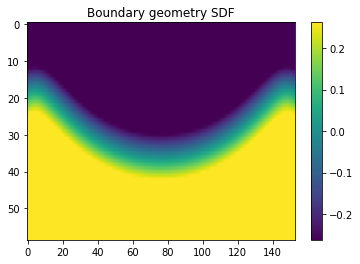

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = 'sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the unstaggered sdf for the exact solution
sdf = read_sdf('exact_solution_surface_periodic_base_pad_0.6', 2)
# Load the staggered sdfs
sdf_x = read_sdf('exact_solution_surface_periodic_base_pad_x_0.6', 2)
sdf_y = read_sdf('exact_solution_surface_periodic_base_pad_y_0.6', 2)

plt.imshow(sdf.data.T, aspect='auto')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

In [2]:
# Set up the exact solution
import numpy as np

# Use SDF grid
grid = sdf.grid

# Misc parameters
c0 = 1
m = 8
A = 0.25

# Functions required
def x1(x, y, A):
    return x - A*np.sin(x)*np.cosh(y)

def y1(x, y, A):
    return y - A*np.cos(x)*np.sinh(y)

def c(x, y, A, c0):
    term1 = (1-A*np.cos(x)*np.cosh(y))**2
    term2 = (A*np.sin(x)*np.sinh(y))**2
    return c0*(term1 + term2)**-0.5

def alpha(m, c0):
    return c0*np.sqrt(m**2+(np.pi/2)**2)

def u(t, x, y, c0, m, A):
    x1_vals = x1(x, y, A)
    y1_vals = y1(x, y, A)
    alp = alpha(m, c0)
    return np.cos(m*x1_vals-alp*t)*np.cos(np.pi*y1_vals/2)

xvals = np.linspace(0, 2*np.pi, grid.shape[0]-8)  # Trim off the edges where we will have bcs
yvals = np.linspace(-3*np.pi/4, 0, grid.shape[1]-4)  # -3pi/4

xmsh, ymsh = np.meshgrid(xvals, yvals, indexing='ij')

u0 = u(0, xmsh, ymsh, c0, m, A)

In [3]:
# Need to set up the subdomains
import devito as dv

# Note that we are leaving a 4 point pad on each side to ensure stencils generate correctly
class MainDomain(dv.SubDomain):  # Main section of the grid
    name = 'main'
    def __init__(self):
        super().__init__()            

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', 4, 4), y: ('middle', 0, 4)}
    
class Left(dv.SubDomain):  # Left wraparound region for periodic bcs
    name = 'left'
    def __init__(self):
        super().__init__()

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('left', 4), y: y}
    
class Right(dv.SubDomain):  # Right wraparound region for periodic bcs
    name = 'right'
    def __init__(self):
        super().__init__()

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('right', 4), y: y}

class Base(dv.SubDomain):  # Base with zero flux (centre)
    name = 'base'
    def __init__(self):
        super().__init__()

    def define(self, dimensions):
        x, y = dimensions
        return {x: ('middle', 4, 4), y: ('right', 4)}
    
main_domain = MainDomain()
left = Left()
right = Right()
base = Base()

new_grid = dv.Grid(shape=grid.shape, extent=grid.extent, origin=grid.origin, dimensions=grid.dimensions,
                   subdomains=[main_domain, left, right, base])

In [4]:
from schism import BoundaryGeometry

# Rebuild the SDF on the new grid so we can use these subdomains

new_sdf = dv.Function(name='sdf', grid=new_grid, space_order=sdf.space_order)
new_sdf.data[:] = sdf.data[:]

new_sdf_x = dv.Function(name='sdf_x', grid=new_grid, space_order=sdf_x.space_order)
new_sdf_x.data[:] = sdf_x.data[:]

new_sdf_y = dv.Function(name='sdf_y', grid=new_grid, space_order=sdf_y.space_order)
new_sdf_y.data[:] = sdf_y.data[:]

bg = BoundaryGeometry((new_sdf, new_sdf_x, new_sdf_y))

Operator `normals` ran in 0.01 s


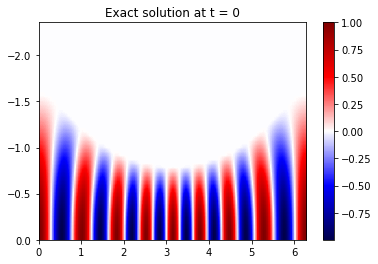

In [5]:
# Plot the solution masked with the interior mask
import sympy as sp

# interior_mask = bg.interior_mask[(sp.core.numbers.Zero(), sp.core.numbers.Zero())][4:-4]
interior_mask = y1(xmsh, ymsh, A) > -1
u0[np.logical_not(interior_mask)] = 0

plt.imshow(u0.T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.title("Exact solution at t = 0")
plt.colorbar()
plt.show()

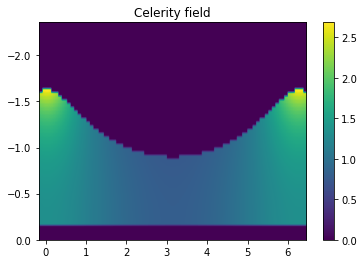

In [6]:
# Set up the velocity field
cel = dv.Function(name='vel', grid=new_grid)
# Cap the velocity at 3, as these points are outside the domain anyway
# vel_data = np.minimum(c(xmsh, ymsh, A, c0), 3)
cel_data = c(xmsh, ymsh, A, c0)
cel_data[np.logical_not(interior_mask)] = 0
# Add the edges
cel_data_full = np.concatenate((cel_data[-5:-1], cel_data, cel_data[1:5]))
cel.data[:, :-4] = cel_data_full[:]

plt.imshow(cel.data.T, extent=(-4*grid.spacing[0], 2*np.pi+4*grid.spacing[0], 0, -3*np.pi/4), aspect='auto')
plt.title("Celerity field")
plt.colorbar()
plt.show()

In [7]:
# Set the timestep at 10% of critical timestep
dt = 0.1*new_grid.spacing[0]/np.amax(cel.data)

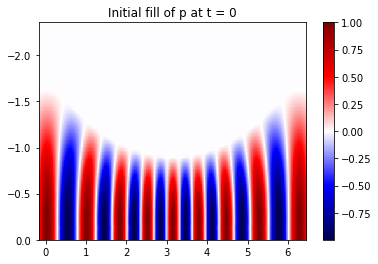

In [8]:
# Set up the TimeFunctions
import devito as dv

s_o = 4
p = dv.TimeFunction(name='p', grid=grid, space_order=s_o,
                    time_order=1, staggered=dv.NODE)
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=s_o,
                          time_order=1)

# Initialise the zero timestep
p.data[0, :, :-4] = np.concatenate((u0[-5:-1], u0, u0[1:5]))
p.data[0, :, -4:] = p.data[0, :, -8:-4]  # Mirror below the zero flux bc

# Think initial v should be zero

plt.imshow(p.data[0].T, extent=(-4*grid.spacing[0], 2*np.pi+4*grid.spacing[0], 0, -3*np.pi/4),
                                aspect='auto', cmap='seismic')
plt.title("Initial fill of p at t = 0")
plt.colorbar()
plt.show()

In [9]:
rho = 1
# Pressure update
eq_p = dv.Eq(p.forward, p + dt*rho*cel**2*(v[0].dx + v[1].dy), subdomain=main_domain)
# Velocity updates
eq_vx = dv.Eq(v[0].forward, v[0] + dt*p.dx/rho, subdomain=main_domain)
eq_vy = dv.Eq(v[1].forward, v[1] + dt*p.dy/rho, subdomain=main_domain)

In [10]:
# Set up periodic BCs
t = new_grid.stepping_dim

x, y = new_grid.dimensions

left_bcs_p = [dv.Eq(p[t+1, i, y], p[t+1, new_grid.shape[0]-9+i, y], subdomain=left) for i in range(4)]
right_bcs_p = [dv.Eq(p[t+1, new_grid.shape[0]-4+i, y], p[t+1, i+5, y], subdomain=right) for i in range(4)]
left_bcs_vx = [dv.Eq(v[0][t+1, i, y], v[0][t+1, new_grid.shape[0]-9+i, y], subdomain=left) for i in range(4)]
right_bcs_vx = [dv.Eq(v[0][t+1, new_grid.shape[0]-4+i, y], v[0][t+1, i+5, y], subdomain=right) for i in range(4)]
left_bcs_vy = [dv.Eq(v[1][t+1, i, y], v[1][t+1, new_grid.shape[0]-9+i, y], subdomain=left) for i in range(4)]
right_bcs_vy = [dv.Eq(v[1][t+1, new_grid.shape[0]-4+i, y], v[1][t+1, i+5, y], subdomain=right) for i in range(4)]

periodic_bcs_p = left_bcs_p + right_bcs_p
periodic_bcs_v = left_bcs_vx + right_bcs_vx + left_bcs_vy + right_bcs_vy

In [11]:
# Set up zero-flux bc
ymax = new_grid.shape[1] - 1  # Max y index
# Mirror pressure around index 4 (5->3, 6->2, 7->1, 8->0)
zero_flux_p = [dv.Eq(p[t+1, x, ymax-4+i], p[t+1, x, ymax-4-i], subdomain=base) for i in range(1, 5)]
# Mirror vx around index 4
zero_flux_vx = [dv.Eq(v[0][t+1, x, ymax-4+i], v[0][t+1, x, ymax-4-i], subdomain=base) for i in range(1, 5)]
# Mirror vy around index 4 (4->3, 5->2, 6->1, 7->0)
zero_flux_vy = [dv.Eq(v[1][t+1, x, ymax-4+i], v[0][t+1, x, ymax-3-i], subdomain=base) for i in range(1, 5)]

In [12]:
# Set up number of timesteps
t_max = 2*np.pi/c0

nsteps = t_max/dt
nsteps

Data(3863.64177499)

In [14]:
op = dv.Operator([eq_vx, eq_vy] + periodic_bcs_v + zero_flux_vx + zero_flux_vy
                 + [eq_p] + periodic_bcs_p + zero_flux_p)

In [15]:
op.apply(dt=dt, t_M=int(nsteps))

Operator `Kernel` ran in 0.09 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.03890100000000068, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0009960000000000155, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.003810000000000166, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.0434280000000001, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section4', rank=None),
                     PerfEntry(time=0.0003980000000000031, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section5', rank=None),
                     PerfEntry(time=0.0010230000000000133, gflopss=0

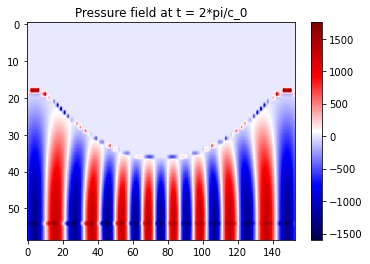

In [17]:
# Remember to trim edges where periodic bcs are applied
# Index in the buffer where the final timestep should be stored:
ind = (int(nsteps)) % 2
# plt.imshow(p.data[ind, 4:-4, :-4].T, extent=(0, 2*np.pi, 0, -3*np.pi/4), aspect='auto', cmap='seismic')
plt.imshow(p.data[ind].T, aspect='auto', cmap='seismic')
plt.title("Pressure field at t = 2*pi/c_0")
plt.colorbar()
plt.show()